# Importations

In [2]:
%matplotlib notebook
import orbit_modelling_library as orbit
import math as m
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
rc('text', usetex = True)

# 3D - plot of $\chi^2$ as a function of $\alpha$ and $\lambda$

In [13]:
def chi_2(observation, model, delta_radar, delta_accelerometer, delta_initial_position, delta_initial_speed):
    if len(observation.t) != len(model.t):
        print("Error : the observation and the model are not sampled at the same times")
        return
    for i in range(len(observation.t)):
        if observation.t[i] != model.t[i]:
            print("Error : the observation and the model are not sampled at the same times")
            return
    
    T = observation.t
    time_step = T[1] - T[0]
    total_time_in_days = int((T[-1] - T[0]) / 86400)
    
    chi_2 = 0
    for k in range(total_time_in_days + 1):
        i = int(k * 86400 / time_step)
        delta = np.sqrt(delta_radar**2 + delta_initial_position**2 + ((i * time_step) * delta_initial_speed)**2 + 1/12 * i * (4 * i**2 - 1) * time_step**4 * delta_accelerometer**2)
        
        X_obs, X_mod = observation.X[i] + np.random.normal(0, delta), model.X[i]
        Y_obs, Y_mod = observation.Y[i] + np.random.normal(0, delta), model.Y[i]
        Z_obs, Z_mod = observation.Z[i] + np.random.normal(0, delta), model.Z[i]

        chi_2 += ((X_obs - X_mod)**2 + (Y_obs - Y_mod)**2 + (Z_obs - Z_mod)**2) / (2 * delta**2)
    return chi_2

In [14]:
def grid_analysis(time_isot_start, time_isot_end, n_points_t, target_files,
         lambda_start, lambda_end, n_points_lambda, 
         alpha_start, alpha_end, n_points_alpha, 
         delta_radar, delta_accelerometer, delta_initial_position, delta_initial_speed, 
         Bodies = [i + 1 for i in range(10)], type_model = "Newton", alpha_model = 10**(-4), lambdaa_model = 10**12,
         radiation = False, solar_wind = False, 
         reflectivity_sat = 0.5, radius_sat = 0.63, mass_sat = 100, plasma_speed = 450000):
    
    target_file = target_files + "_model"
    model = orbit.Orbit_model(time_isot_start, time_isot_end, n_points_t, target_file, Bodies, type_model, alpha_model, lambdaa_model, radiation, solar_wind, reflectivity_sat, radius_sat, mass_sat, plasma_speed)
    model.load()
    
    Lambda1 = [10**(9) * (10**(11) / 10**(9))**(i / (8 - 1)) for i in range(8)] # a modifier
    Lambda2 = [10**(11) * (10**(15) / 10**(11))**(i / (16 - 1)) for i in range(16)] # a modifier
    Lambda3 = [10**(15) * (10**(17) / 10**(15))**(i / (8 - 1)) for i in range(8)] # a modifier
    Lambda4 = [10**(17) * (10**(19) / 10**(17))**(i / (8 - 1)) for i in range(8)] # a modifier
    Lambda = Lambda1 + Lambda2 + Lambda3 + Lambda4 # a modifer
    Alpha = [alpha_start * (alpha_end / alpha_start)**(i / (n_points_alpha - 1)) for i in range(n_points_alpha)]
    Z = [[0 for j in range(len(Alpha))] for i in range(len(Lambda))]
    for i in range(len(Lambda)):
        for j in range(len(Alpha)):
            lambdaa = Lambda[i]
            alpha = Alpha[j]
            
            target_file = target_files + "_lambda_=_" + str(lambdaa) + "_alpha_=_" + str(alpha)
            observation = orbit.Orbit_model(time_isot_start, time_isot_end, n_points_t, target_file, Bodies, "Yukawa", alpha, lambdaa, radiation, solar_wind, reflectivity_sat, radius_sat, mass_sat, plasma_speed)
            observation.load()
            
            sum_chi_2 = 0
            for k in range(500): # greatly lowers the variations on chi_2
                sum_chi_2 += chi_2(observation, model, delta_radar, delta_accelerometer, delta_initial_position, delta_initial_speed)
            average_chi_2 = sum_chi_2 / 500
            
            Z[i][j] = average_chi_2
    
    Z_model = chi_2(model, model, delta_radar, delta_accelerometer, delta_initial_position, delta_initial_speed)
    
    Z = np.asarray(Z)
    m = min(np.amin(Z), Z_model)
    Z -= m
    
    E = []
    for i in range(len(Lambda)):
        for j in range(len(Alpha)):
            if Z[i][j] > 6.7:
                E.append((Lambda[i], Alpha[j]))
    
    return(Z)

In [15]:
def drawing(lambda_start, lambda_end, n_points_lambda, 
            alpha_start, alpha_end, n_points_alpha, 
            grid_alpha_lambda):
    
    Lambda1 = [10**(9) * (10**(11) / 10**(9))**(i / (8 - 1)) for i in range(8)] # a modifier
    Lambda2 = [10**(11) * (10**(15) / 10**(11))**(i / (16 - 1)) for i in range(16)] # a modifier
    Lambda3 = [10**(15) * (10**(17) / 10**(15))**(i / (8 - 1)) for i in range(8)] # a modifier
    Lambda4 = [10**(17) * (10**(19) / 10**(17))**(i / (8 - 1)) for i in range(8)] # a modifier
    Lambda = Lambda1 + Lambda2 + Lambda3 + Lambda4 # a modifer
    Alpha = [alpha_start * (alpha_end / alpha_start)**(i / (n_points_alpha - 1)) for i in range(n_points_alpha)]
    X = np.log10(Lambda)
    Y = np.log10(Alpha)
    X, Y = np.meshgrid(Y, X)
    Z = np.log10(np.asarray(grid_alpha_lambda))

    fig = plt.figure(1)
    ax = fig.gca(projection = '3d')
    ax.set_title("$\chi^2$ as a function of $\\alpha$ and $\lambda$ for a 1-month experiment")
    #ax.set_xlim(10, 20)
    #ax.set_ylim(-8, -7) # beware
    ax.set_xlabel("$log(\\alpha$)")
    ax.set_ylabel("$log(\lambda$ en m)")
    ax.set_zlabel("$log(\chi^2)$")
    ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = 'viridis', edgecolor = 'none')
    plt.show()

In [ ]:
delta_radar = 1
delta_accelerometer = 10**(-12)
delta_initial_position = delta_radar
delta_initial_speed = 0

Z = grid_analysis("2050-01-01T00:00:00", "2050-02-01T00:00:00", 10**4, "Orbits_1_month", 
         10**(9), 10**(19), 40, 
         10**(-10), 10**(-1), 36, 
         delta_radar, delta_accelerometer, delta_initial_position, delta_initial_speed)

drawing(10**(9), 10**(19), 40, 
         10**(-10), 10**(-1), 36, 
        Z)

In [21]:
for z in Z:
    print(z)

[0.79161997 0.93128935 0.73221638 0.52459523 1.44751932 0.20641795
 0.59628047 1.35729126 0.74515525 1.06882898 0.97129113 1.13292873
 0.72811209 1.1099512  0.83923372 1.14339085 0.91207271 1.36607753
 1.01035578 1.38280352 0.8905739  1.32069675 1.03965119 1.53540955
 1.03013157 0.66459037 0.75461761 1.40514334 1.25318602 1.3193468
 0.83223236 1.18484153 0.68290042 1.21502174 1.39440769 1.40331919]
[0.85062709 1.16924432 0.68834341 1.19492663 1.00291548 0.84385198
 0.98916393 0.43960874 1.74998828 0.8595345  1.11870826 1.2396937
 0.995659   1.07249932 1.02604484 1.10949092 1.00992136 1.56156877
 0.51400819 1.43113422 1.03248523 1.00311625 0.31497167 0.771003
 1.01723371 0.82253992 1.05714139 0.86224257 0.85271615 0.76740936
 1.23324405 1.5959646  0.96189261 0.91731419 1.76493068 1.30126292]
[0.76626261 1.02808937 0.68688841 1.27462302 1.48967569 0.93717012
 0.84635781 1.47486309 0.69365057 0.8721257  1.02748967 1.31496368
 1.23430867 1.38353034 1.10890816 0.93136145 0.92861344 1.728281

0.29540147153887275


<IPython.core.display.Javascript object>


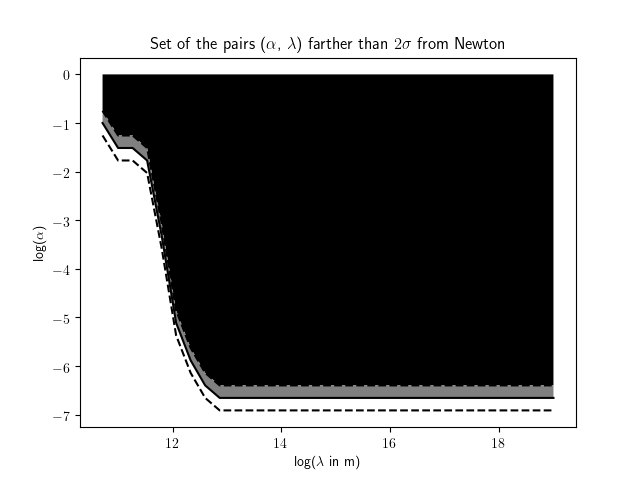

In [57]:
Lambda1 = [10**(9) * (10**(11) / 10**(9))**(i / (8 - 1)) for i in range(8)] # a modifier
Lambda2 = [10**(11) * (10**(15) / 10**(11))**(i / (16 - 1)) for i in range(16)] # a modifier
Lambda3 = [10**(15) * (10**(17) / 10**(15))**(i / (8 - 1)) for i in range(8)] # a modifier
Lambda4 = [10**(17) * (10**(19) / 10**(17))**(i / (8 - 1)) for i in range(8)] # a modifier
Lambda = Lambda1 + Lambda2 + Lambda3 + Lambda4 # a modifer
Alpha = [10**(-10)* (10**(-1) / 10**(-10))**(i / (36 - 1)) for i in range(36)] + [0.1 * 10**(1/4)]

# we look for the size of the fluctuations
var = np.sqrt(np.var(Z[:][:4]))
print(var)

# we research the points that are at chi2 > 6.7 +_ fluct
X = []
#Y1 = []
Y2 = []
#Y3 = []
Y2p = []
Y2m = []
for i in range(40):
    test1 = False
    test2 = False
    test3 = False
    for j in range(36):
#        if ((test1 != True) and (Z[i][j] > 6.7 - var)):
#            test1 = True
#            X.append(np.log10(Lambda[i]))
#            Y1.append(np.log10(Alpha[j]))
        if ((test2 != True) and (Z[i][j] > 6.7)):
            test2 = True
            X.append(np.log10(Lambda[i]))
            Y2.append(np.log10(Alpha[j]))
            Y2m.append(np.log10(Alpha[j-1]))
            Y2p.append(np.log10(Alpha[j+1]))
#        if ((test3 != True) and (Z[i][j] > 6.7 + var)):
#            test3 = True
#            Y3.append(np.log10(Alpha[j]))

plt.figure(2)
plt.title("Set of the pairs ($\\alpha$, $\lambda$) farther than $2\sigma$ from Newton")
plt.xlabel("log($\lambda$ in m)")
plt.ylabel("log($\\alpha$)")
#plt.plot(X, Y1, 'k--')
plt.plot(X, Y2, 'k')
#plt.plot(X, Y3, 'k--')
plt.plot(X, Y2m, 'k--')
plt.plot(X, Y2p, 'k--')
plt.fill_between(X, 0, Y2p, facecolor = "black")
plt.fill_between(X, Y2p, Y2, facecolor = 'grey')
plt.fill_between(X, Y2, Y2m, facecolor = 'white')
plt.show()

0.29540147153887275
[10.714285714285714, 11.0, 11.0, 11.266666666666667, 11.533333333333333, 11.8, 12.066666666666666, 12.333333333333334, 12.6, 12.866666666666667, 13.133333333333333, 13.4, 13.5, 16.705]


<IPython.core.display.Javascript object>


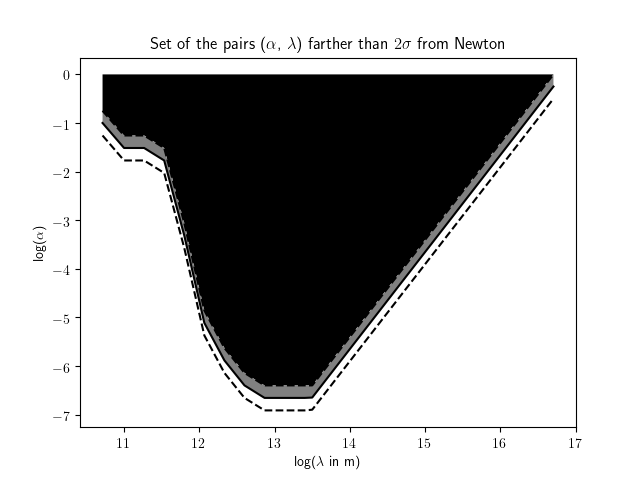

In [65]:
Lambda1 = [10**(9) * (10**(11) / 10**(9))**(i / (8 - 1)) for i in range(8)] # a modifier
Lambda2 = [10**(11) * (10**(15) / 10**(11))**(i / (16 - 1)) for i in range(16)] # a modifier
Lambda3 = [10**(15) * (10**(17) / 10**(15))**(i / (8 - 1)) for i in range(8)] # a modifier
Lambda4 = [10**(17) * (10**(19) / 10**(17))**(i / (8 - 1)) for i in range(8)] # a modifier
Lambda = Lambda1 + Lambda2 + Lambda3 + Lambda4 # a modifer
Alpha = [10**(-10)* (10**(-1) / 10**(-10))**(i / (36 - 1)) for i in range(36)] + [0.1 * 10**(1/4)]

# we look for the size of the fluctuations
var = np.sqrt(np.var(Z[:][:4]))
print(var)

# we research the points that are at chi2 > 6.7 +_ fluct
X = []
#Y1 = []
Y2 = []
#Y3 = []
Y2p = []
Y2m = []
for i in range(40):
    test1 = False
    test2 = False
    test3 = False
    for j in range(36):
#        if ((test1 != True) and (Z[i][j] > 6.7 - var)):
#            test1 = True
#            X.append(np.log10(Lambda[i]))
#            Y1.append(np.log10(Alpha[j]))
        if ((test2 != True) and (Z[i][j] > 6.7)):
            test2 = True
            X.append(np.log10(Lambda[i]))
            Y2.append(np.log10(Alpha[j]))
            Y2m.append(np.log10(Alpha[j-1]))
            Y2p.append(np.log10(Alpha[j+1]))
#        if ((test3 != True) and (Z[i][j] > 6.7 + var)):
#            test3 = True
#            Y3.append(np.log10(Alpha[j]))

X_extra = [13.5, 16.83 - 1/8]
Y_extra = [-6.65, - 1/4]
Y_extra_m = [y - 1/4 for y in Y_extra]
Y_extra_p = [y + 1/4 for y in Y_extra]

X_new = X[:12] + X_extra
Y_new = Y2[:12] + Y_extra
Y_new_m = Y2m[:12] + Y_extra_m
Y_new_p = Y2p[:12] + Y_extra_p

print(X_new)

plt.figure(3)
plt.title("Set of the pairs ($\\alpha$, $\lambda$) farther than $2\sigma$ from Newton")
plt.xlabel("log($\lambda$ in m)")
plt.ylabel("log($\\alpha$)")
#plt.plot(X, Y1, 'k--')
plt.plot(X_new, Y_new, 'k')
#plt.plot(X, Y3, 'k--')
plt.plot(X_new, Y_new_m, 'k--')
plt.plot(X_new, Y_new_p, 'k--')
plt.fill_between(X_new, 0, Y_new_p, facecolor = "black")
plt.fill_between(X_new, Y_new_p, Y_new, facecolor = 'grey')
plt.fill_between(X_new, Y_new, Y_new_m, facecolor = 'white')
plt.show()